In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Dataloaders for ShapeNetCore and R2N2
This tutorial shows how to:
- Load models from ShapeNetCore and R2N2 using PyTorch3D's data loaders.
- Pass the loaded datasets to `torch.utils.data.DataLoader`.
- Render ShapeNetCore models with PyTorch3D's renderer.
- Render R2N2 models with the same orientations as the original renderings in the dataset.
- Visualize R2N2 model voxels.

## 0. Install and import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
import numpy as np
import torch

from pytorch3d.datasets import (
    R2N2,
    ShapeNetCore,
    collate_batched_meshes,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-11-22 00:02:58--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1606 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.1’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-11-22 00:02:58 (63.3 MB/s) - ‘plot_image_grid.py.1’ saved [1606/1606]



OR if running locally uncomment and run the following cell:

In [4]:
# from utils import image_grid

## 1. Load the datasets

If you haven't already downloaded the ShapeNetCore dataset, first do that following the instructions here: https://www.shapenet.org/. ShapeNetCore is a subset of the ShapeNet dataset. In PyTorch3D we support both version 1 (57 categories) and version 2 (55 categories).

Then modify `SHAPENET_PATH` below to you local path to the ShapeNetCore dataset folder. 

In [17]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
SHAPENET_PATH = "/floppy/datasets/ShapeNetCore.v2/"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH, version=2)

The R2N2 dataset can be downloaded using the instructions here: http://3d-r2n2.stanford.edu/. Look at the links for `ShapeNetRendering` and `ShapeNetVox32`. The R2N2 dataset contains 13 categories that are a subset of the ShapeNetCore v.1
dataset. The R2N2 dataset also contains its own 24 renderings of each object and voxelized models.

Then modify `R2N2_PATH` and `SPLITS_PATH` below to your local R2N2 dataset folder path and splits file path respectively. Here we will load the `train` split of R2N2 and ask the voxels of each model to be returned.

In [7]:
R2N2_PATH = "/floppy/datasets/ShapeNetCore.v2"
SPLITS_PATH = "None"
r2n2_dataset = R2N2("train", SHAPENET_PATH, R2N2_PATH, SPLITS_PATH, return_voxels=True)

FileNotFoundError: [Errno 2] No such file or directory: 'None'

We can retrieve a model by indexing into the loaded dataset. For both ShapeNetCore and R2N2, we can examine the category this model belongs to (in the form of a synset id, equivalent to wnid described in ImageNet's API: http://image-net.org/download-API), its model id, and its vertices and faces.

In [18]:
print(len(shapenet_dataset))
shapenet_model = shapenet_dataset[6]
print("This model belongs to the category " + shapenet_model["synset_id"] + ".")
print("This model has model id " + shapenet_model["model_id"] + ".")
model_verts, model_faces = shapenet_model["verts"], shapenet_model["faces"]

52472
This model belongs to the category 03938244.
This model has model id 7b2bc135a01a7ff59be1712545749b62.


We can use its vertices and faces to form a `Meshes` object which is a PyTorch3D datastructure for working with batched meshes.

In [19]:
model_textures = TexturesVertex(verts_features=torch.ones_like(model_verts, device=device)[None])
shapenet_model_mesh = Meshes(
    verts=[model_verts.to(device)],   
    faces=[model_faces.to(device)],
    textures=model_textures
)

With R2N2, we can further examine R2N2's original renderings. For instance, if we would like to see the second and third views of the eleventh objects in the R2N2 dataset, we can do the following:

In [ ]:
r2n2_renderings = r2n2_dataset[10,[1,2]]
image_grid(r2n2_renderings.numpy(), rows=1, cols=2, rgb=True)

## 2. Use the datasets with `torch.utils.data.DataLoader`

Training deep learning models, usually requires passing in batches of inputs. The `torch.utils.data.DataLoader` from PyTorch helps us do this. PyTorch3D provides a function `collate_batched_meshes` to group the input meshes into a single `Meshes` object which represents the batch. The `Meshes` datastructure can then be used directly by other PyTorch3D ops which might be part of the deep learning model (e.g. `graph_conv`).

For R2N2, if all the models in the batch have the same number of views, the views, rotation matrices, translation matrices, intrinsic matrices and voxels will also be stacked into batched tensors.

**NOTE**: All models in the `val` split of R2N2 have 24 views, but there are 8 models that split their 24 views between `train` and `test` splits, in which case `collate_batched_meshes` will only be able to join the matrices, views and voxels as lists. However, this can be avoided by loading only one view of each model by setting `return_all_views = False`.

In [ ]:
batch_size = 12
r2n2_single_view = R2N2("train", SHAPENET_PATH, R2N2_PATH, SPLITS_PATH, return_all_views=False, return_voxels=True)
r2n2_loader = DataLoader(r2n2_single_view, batch_size=batch_size, collate_fn=collate_batched_meshes)

Let's visualize all the views (one for each model) in the batch:

In [ ]:
it = iter(r2n2_loader)
r2n2_batch = next(it)
batch_renderings = r2n2_batch["images"] # (N, V, H, W, 3), and in this case V is 1.
image_grid(batch_renderings.squeeze().numpy(), rows=3, cols=4, rgb=True)

## 3. Render ShapeNetCore models with PyTorch3D's differentiable renderer

Both `ShapeNetCore` and `R2N2` dataloaders have customized `render` functions that support rendering models by specifying their model ids, categories or indices using PyTorch3D's differentiable renderer implementation.

In [20]:
# Rendering settings.
R, T = look_at_view_transform(1.0, 1.0, 90)
cameras = OpenGLPerspectiveCameras(R=R, T=T, device=device)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(location=torch.tensor([0.0, 1.0, -2.0], device=device)[None],device=device)

First we will try to render three models by their model ids:

/home/shubham/anaconda3/envs/cs236-dp/lib/python3.9/site-packages/pytorch3d/io/mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)
/home/shubham/anaconda3/envs/cs236-dp/lib/python3.9/site-packages/pytorch3d/transforms/transform3d.py:780: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


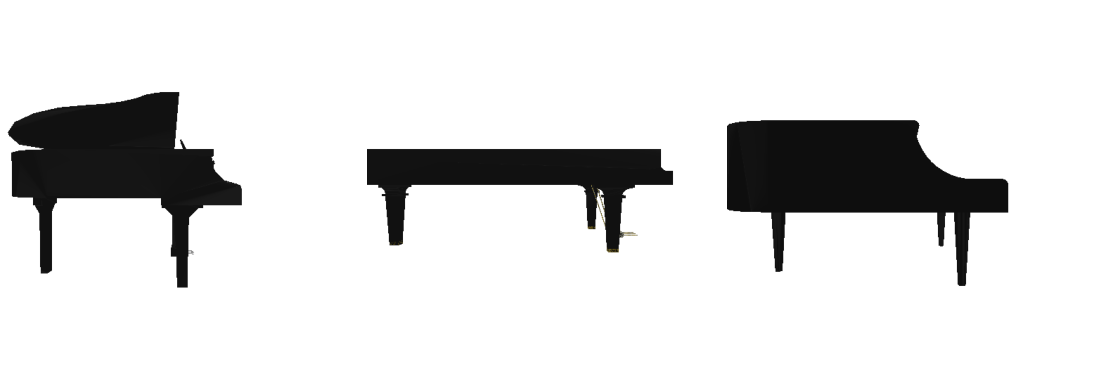

In [21]:
images_by_model_ids = shapenet_dataset.render(
    model_ids=[
        "13394ca47c89f91525a3aaf903a41c90",
        "14755c2ee8e693aba508f621166382b0",
        "156c4207af6d2c8f1fdc97905708b8ea",
    ],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_model_ids.cpu().numpy(), rows=1, cols=3, rgb=True)

Suppose we would like to render the first three models in the dataset, we can render models by their indices:

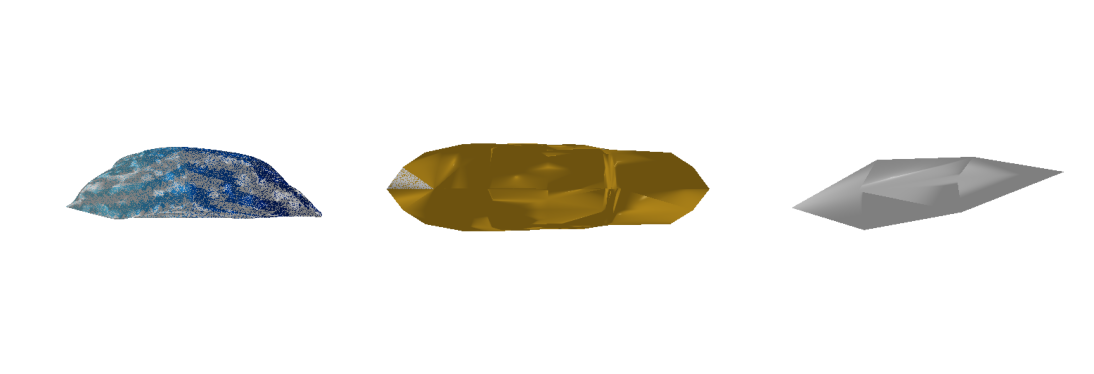

In [22]:
images_by_idxs = shapenet_dataset.render(
    idxs=list(range(3)),
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_idxs.cpu().numpy(), rows=1, cols=3, rgb=True)

Alternatively, if we are not interested in any particular models but would like see random models from some specific categories, we can do that by specifying `categories` and `sample_nums`. For example, if we would like to render 2 models from the category "faucet" and 3 models from the category "chair", we can do the following:

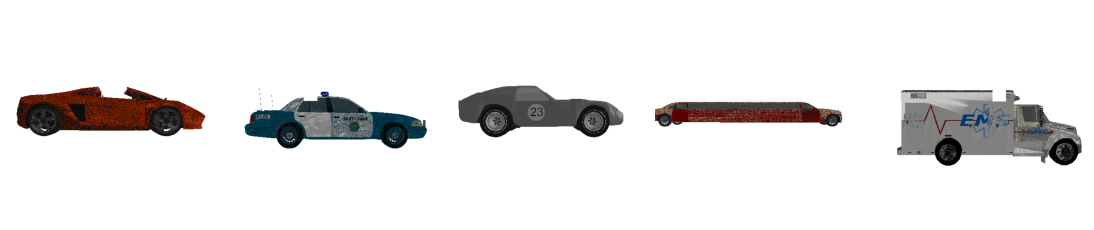

In [27]:
images_by_categories = shapenet_dataset.render(
    categories=["car"],
    sample_nums=[5],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_categories.cpu().numpy(), rows=1, cols=5, rgb=True)

If we are not interested in any particular categories and just would like to render some random models from the whole dataset, we can set the number of models to be rendered in `sample_nums` and not specify any `categories`:

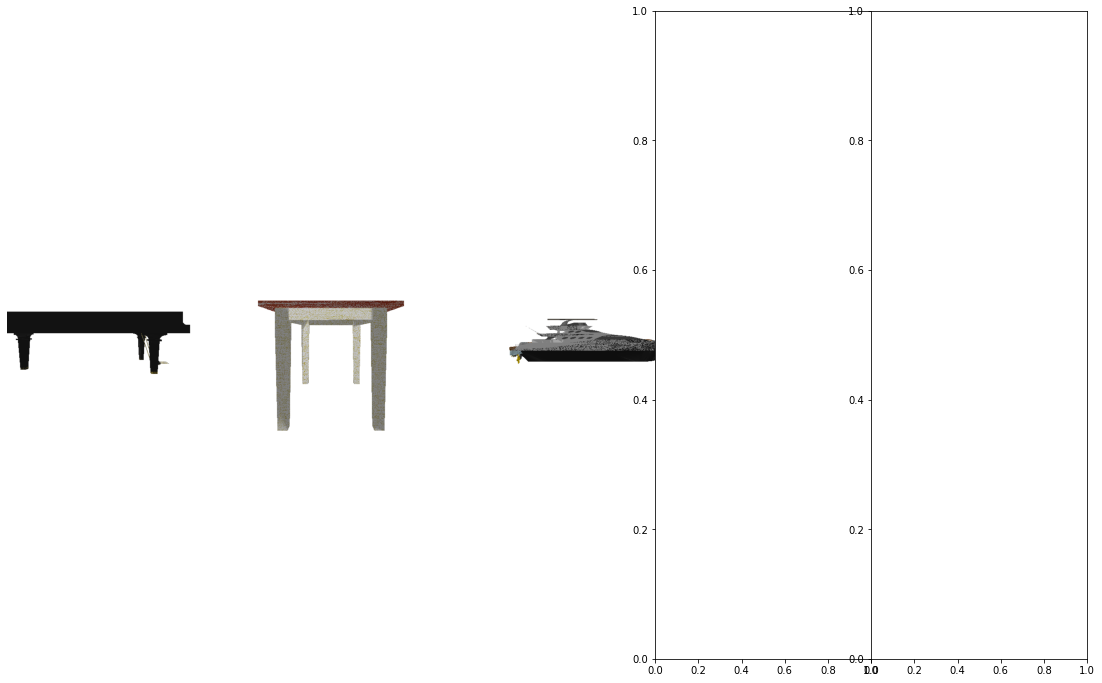

In [28]:
random_model_images = shapenet_dataset.render(
    sample_nums=[3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(random_model_images.cpu().numpy(), rows=1, cols=5, rgb=True)

## 4. Render R2N2 models with the same orientations as the original renderings in the dataset

We can render R2N2 models the same way as we rendered ShapeNetCore models above. In addition, we can also render R2N2 models with the same orientations as the original renderings in the dataset. For this we will use R2N2's customized `render` function and a different type of PyTorch3D camera called `BlenderCamera`.

In this example, we will render the seventh model with the same orientations as its second and third views. First we will retrieve R2N2's original renderings to compare with the result.

In [ ]:
original_rendering = r2n2_dataset[6,[1,2]]["images"]
image_grid(original_rendering.numpy(), rows=1, cols=2, rgb=True)

Next, we will visualize PyTorch3D's renderings:

In [ ]:
r2n2_oriented_images = r2n2_dataset.render(
    idxs=[6],
    view_idxs=[1,2],
    device=device,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(r2n2_oriented_images.cpu().numpy(), rows=1, cols=2, rgb=True)

## 5. Visualize R2N2 models' voxels

R2N2 dataloader also returns models' voxels. We can visualize them by utilizing R2N2's `render_vox_to_mesh` function. This will cubify the voxels to a Meshes object, which will then be rendered.

In this example we will visualize the tenth model in the dataset with the same orientation of its second and third views. First we will retrieve R2N2's original renderings to compare with the result.

In [ ]:
r2n2_model = r2n2_dataset[9,[1,2]]
original_rendering = r2n2_model["images"]
image_grid(original_rendering.numpy(), rows=1, cols=2, rgb=True)

Next, we will pass the voxels to `render_vox_to_mesh`:

In [29]:
vox_render = render_cubified_voxels(r2n2_model["voxels"], device=device)
image_grid(vox_render.cpu().numpy(), rows=1, cols=2, rgb=True)

NameError: name 'r2n2_model' is not defined